# Figure 4

**Figure 4 | Logistic regression of sEEG model similarity and behavior.** (A) Cortical locations of bipolar sEEG contact midpoints of model $\rho$s included in regression. Electrodes were included if they were located in the superior temporal cortex or the insula. Included electrodes had the maximum $\rho$ value per model. Three electrodes per participant, with 17 unique electrodes total. (B) The logistic regression significantly predicted trial-wise accuracy on the temporal expectation task from a combination of neural and stimulus variables (Logistic regression: $R^2McF$ = 0.09, p < $10^{-5}$). Regression coefficients $\beta$[95% CI] for relative jitter ($\beta_{jitter}$ = 0.76[0.63, 0.88], p < $10^{-5}$), number of tones ($\beta_{tones}$ = 0.15[0.03, 0.27], p = 0.02), and $\rho_{SAMy}$ were significant ($\beta_{SAMy}$ = 0.28[0.14, 0.42], p = 1.05x$10^{-4}$). The regression was still significant without stimulus features and $\rho_{SAMy}$ was the only significant predictor of accuracy (Logistic regression: $R^2McF$ = 6.9x$10^{-3}$, p = 0.01; $\beta_{SAMy}$ = 0.26[0.10, 0.35], p = 5.84x$10^{-4}$, not shown). A regression of $\rho_{SAMy}$ alone was also significant (Logistic regression: $R^2McF$ = 4.20x$10^{-3}$; p = 5.15x$10^{-3}$; $\beta_{SAMy}$ = 0.16[0.05, 0.27], p = 4.92x$10^{-3}$, not shown) (C) Representative sample of 240 trials showing relationship of $\rho_{SAMy}$ to behavioral accuracy (probability correct). Solid line is predicted P(Correct) from $\beta_{SAMy}$, shading is 95% CI. (D) Like panel C, but for relative jitter. (E) Like panel C for number of tones. 


### imports

In [46]:
import numpy as np
import pandas as pd
import random

import statsmodels.formula.api as smf
from scipy.stats import zscore, false_discovery_control

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

### plotting functions

In [39]:
def plot_logistic_coefficients(model):
    """
    Plots the coefficients of a fitted statsmodels logistic regression model
    with error bars representing the standard errors.
    
    Parameters:
    model : A fitted statsmodels Logit model result
    """

    sns.set_context('talk')
    
    # Extract coefficients and standard errors
    coef = model.params[1:]
    std_err = model.bse[1:]
    
    # Combine into a dataframe
    coef_df = pd.DataFrame({'Predictor': model.params.index[1:], 'Coefficient': coef, 'Error': std_err})
    
    # Define colors
    colors = ['dodgerblue', 'salmon',  'mediumvioletred', 'slategray', 'teal', 'teal', 'teal']

    # tick labels
    tick_labels = [ r'$\rho_{bottomup}$', r'$\rho_{top down}$', r'$\rho_{SAM_y}$', r'$\rho_{control}$', 'ISI', 'relative \n jitter', '# tones']
    
    # Plot
    fig, ax = plt.subplots(1,1, figsize=(10, 6))
    bars = ax.bar(coef_df['Predictor'], coef_df['Coefficient'], yerr=coef_df['Error'].values, capsize=5, color=colors)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ticks = ax.get_xticks()
    ax.set_xticks(ticks, tick_labels)
    #ax.set_xlabel("")
    ax.set_ylabel("Coefficient Estimate")
    #ax.set_title("Logistic Regression Coefficients")
    sns.despine()
    plt.show()

### analysis functions

In [28]:
def make_long_form(wide_form_df):
    rho_features = ['raw_top_rho',
                'raw_btm_rho', 
                'raw_SAM_y_rho',
                'control_rho']

    patients = ['1002', '1005', '1007', '1008', '1009', 
                '1010', '1014']
    
    subjs = np.array([], dtype=str)
    channels = np.array([]) 
    X10s = np.array([])
    models = np.array([])
    rhos = np.array([])
    pFDRs = np.array([])
    norm_rhos = np.array([])
    
    for feature in rho_features:
        subjs = np.concatenate([subjs, wide_form_df['subj'].values])
        channels = np.concatenate([channels, wide_form_df['channel'].values])
        X10s = np.concatenate([X10s, wide_form_df['X10'].values])
        models = np.concatenate([models, np.tile(feature, len(wide_form_df))])
        rhos = np.concatenate([rhos, wide_form_df[feature].abs()])
    
        if feature=='control_rho':
            pFDRs = np.concatenate([pFDRs, np.zeros(shape=len(wide_form_df))])
        else:
            pFDRs = np.concatenate([pFDRs, wide_form_df[feature+'_pFDR']])
         
    
    reorg_dict = {'subj' : subjs,
                  'channel': channels,
                  'X10': X10s,
                  'model': models,
                  'rho': rhos,
                  'pFDR': pFDRs}
    
    reorg_df = pd.DataFrame(reorg_dict)

    return reorg_df

### logistic regression analysis

In [29]:
wide_form_df = pd.read_csv('../../03-results/model_comparison/all_subj_model_behav_control_X10_median_pvals.csv')

reorg_df = make_long_form(wide_form_df)
reorg_df_sig = reorg_df[reorg_df['pFDR']<0.001]

In [31]:
# make dataframe of maximum model rho per region (merged df has df medians, get max median channel)

patients = reorg_df_sig['subj'].unique()
regions = reorg_df_sig['X10'].unique()
features = ['raw_top_rho', 'raw_btm_rho', 'raw_SAM_y_rho', 'control_rho']

df_max = pd.DataFrame([])

for pat in patients:
    df_pat = reorg_df_sig[reorg_df_sig['subj']==pat]

    for region in regions:
        df_pat_region = df_pat[df_pat['X10']==region]

        if df_pat_region.empty:
            pass
        else:

            for feature in features:
                df_model = df_pat_region[df_pat_region['model']==feature]
                df_max = pd.concat([df_max, df_model[df_model['rho']==df_model['rho'].max()]
                                    [['subj', 'channel', 'X10', 'model']]])


In [33]:
# merge dataframe with p-vals and FDR p-vals and exlcude non-significant channels
all_subj = pd.read_csv('../../03-results/model_comparison/all_subj_model_behav_control_X10.csv')
all_subj['subj'] = all_subj['subj'].astype('str')

pval_dfs = []

features = ['raw_top_r', 'raw_top_rho',
          'raw_btm_r', 'raw_btm_rho', 
          'raw_comb_r', 'raw_comb_rho',
          'raw_SAM_y_r', 'raw_SAM_y_rho',
          'raw_SAM_e_r', 'raw_SAM_e_rho', 
          'raw_SAM_i_r', 'raw_SAM_i_rho']

# loop through subjects and add p-values & FDR corrected pvals
patients = ['1002', '1005', '1007', '1008', '1009', '1010', '1014']
for patient in patients:
    pval_path = '../../03-results/perm_test/p_vals/'+patient+'_pvals.csv'
    pval_df = pd.read_csv(pval_path)

    for metric in features:
        # FDR correction
        pval_df[metric+'_pFDR'] = false_discovery_control(pval_df[metric+'_pval'].values, method='bh')

    # add subject ids
    pval_df['subj'] = np.tile(patient, len(pval_df))

    # drop duplicate columns
    pval_df = pval_df.drop(labels=features, axis='columns')
    
    pval_dfs.append(pval_df)

all_subj_pvals = pd.concat(pval_dfs)

df = pd.merge(left=all_subj, right=all_subj_pvals, how='left', on=['subj', 'channel'])

# get only channels where all 3 models are significant
df = df[(df['raw_top_rho_pFDR']<0.001) |
        (df['raw_btm_rho_pFDR']<0.001) |
        (df['raw_SAM_y_rho_pFDR']<0.001)]

In [36]:
# superiortemporal-insula cortex

region = 'SuperiorTemporal-Insula'
features = ['raw_top_rho', 'raw_btm_rho', 'raw_SAM_y_rho', 'control_rho']
zscore_features = ['raw_top_rho', 'raw_btm_rho', 'raw_SAM_y_rho', 'SOA_x', 'rel_jitter', 'abs_jitter', 'n_tones', 'control_rho']

df_region_max_list = []

for patient in patients:

    vals_dfs = []
    for feature in features:
        
        # get channel of with max rho
        channel = df_max[(df_max['subj']==patient) &
                         (df_max['X10']==region) &
                         (df_max['model']==feature)]['channel'].values.tolist()[0]
        
        # get values from channel with max rho
        vals = df[(df['subj']==patient) & 
                  (df['X10']==region) &
                  (df['channel']==channel)][['subj', 'trial', 'Accuracy', 'SOA_x', 'rel_jitter', 'abs_jitter', 'n_tones', feature]]
        vals_dfs.append(vals)

    
    df_subj_feature = pd.merge(left=vals_dfs[0], right=vals_dfs[1], how='left', on=['subj', 'trial', 'Accuracy', 'SOA_x', 'rel_jitter', 'abs_jitter', 'n_tones'])
    df_subj_feature = pd.merge(left=df_subj_feature, right=vals_dfs[2], how='left', on=['subj', 'trial', 'Accuracy', 'SOA_x', 'rel_jitter', 'abs_jitter', 'n_tones'])
    df_subj_feature = pd.merge(left=df_subj_feature, right=vals_dfs[3], how='left', on=['subj', 'trial', 'Accuracy', 'SOA_x', 'rel_jitter', 'abs_jitter', 'n_tones'])

    
    df_region_max_list.append(df_subj_feature)

df_region_max = pd.concat(df_region_max_list, ignore_index=True)

ABS = True #absolute value of rho per trial

if ABS:
    df_region_max[features] = df_region_max[features].abs()

for feature in zscore_features:
    df_region_max[feature+'_zscore']=zscore(df_region_max[feature].values)

formula = 'Accuracy ~ raw_btm_rho_zscore + raw_top_rho_zscore + raw_SAM_y_rho_zscore + control_rho_zscore + SOA_x_zscore + rel_jitter_zscore + n_tones_zscore' 
log_reg = smf.logit(formula, data=df_region_max).fit(cov_type='HC3')
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.522036
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Accuracy   No. Observations:                 1623
Model:                          Logit   Df Residuals:                     1615
Method:                           MLE   Df Model:                            7
Date:                Thu, 25 Sep 2025   Pseudo R-squ.:                 0.09210
Time:                        15:59:31   Log-Likelihood:                -847.26
converged:                       True   LL-Null:                       -933.22
Covariance Type:                  HC3   LLR p-value:                 9.963e-34
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.1803      0.064     18.447      0.000       1.055       1.306
raw_btm_rho_zscore      -0.1294      0.086     -1.499      0.134      -0.299       0.040
raw_top_rho_zscore      -0.0769      0.060     -1.291      0.197      -0.194       0.040
raw_SAM_y_rho_zscore     0.2758      0.071      3.878      0.000       0.136       0.415
control_rho_zscore      -0.0028      0.078     -0.035      0.972      -0.156       0.150
SOA_x_zscore             0.0379      0.059      0.638      0.523      -0.079       0.154
rel_jitter_zscore        0.7576      0.065     11.585      0.000       0.629       0.886
n_tones_zscore           0.1493      0.061      2.431      0.015       0.029       0.270
========================================================================================
"""

In [37]:
log_reg.pvalues

Intercept               5.494155e-76
raw_btm_rho_zscore      1.337974e-01
raw_top_rho_zscore      1.966806e-01
raw_SAM_y_rho_zscore    1.051073e-04
control_rho_zscore      9.718953e-01
SOA_x_zscore            5.234308e-01
rel_jitter_zscore       4.892329e-31
n_tones_zscore          1.505338e-02
dtype: float64

# panel A

This panel contains sEEG electrode location information, and these data are available upon reasonable request, subject to IRB approval.

# panel B

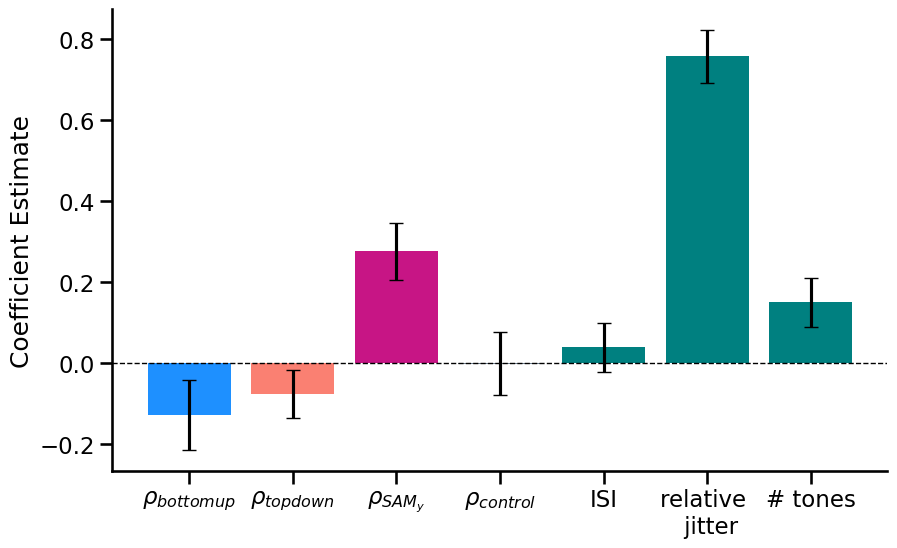

In [40]:
plot_logistic_coefficients(log_reg)

# panel C

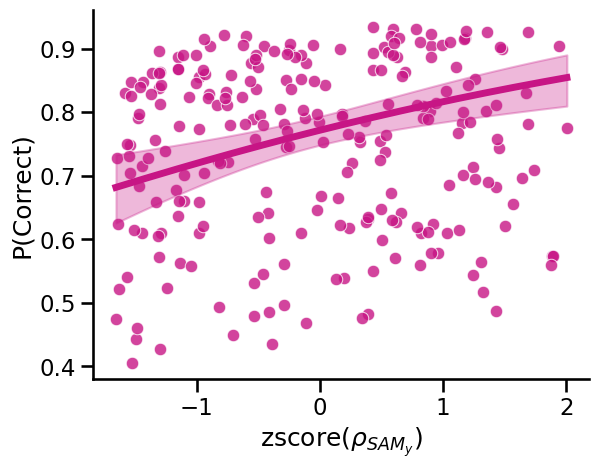

In [43]:
# randomly draw 240 example trials
random.seed(0)
sample_df = df_region_max.sample(240)

y = log_reg.predict(sample_df)

# hold all but zscore(rho_SAMy) at its mean, linearlize zscore(rho_SAMy)
x_df = {'raw_top_rho_zscore' : np.tile(sample_df['raw_top_rho_zscore'].mean(), len(sample_df)), 
        'raw_btm_rho_zscore' : np.tile(sample_df['raw_btm_rho_zscore'].mean(), len(sample_df)),
        'raw_SAM_y_rho_zscore' : np.linspace(sample_df['raw_SAM_y_rho_zscore'].min(),sample_df['raw_SAM_y_rho_zscore'].max(),len(sample_df)),
        'control_rho_zscore' : np.tile(sample_df['control_rho_zscore'].mean(), len(sample_df)),
        'SOA_x_zscore': np.tile(sample_df['SOA_x_zscore'].mean(), len(sample_df)),
        'rel_jitter_zscore':  np.tile(sample_df['rel_jitter_zscore'].mean(), len(sample_df)),
        'abs_jitter_zscore':  np.tile(sample_df['abs_jitter_zscore'].mean(), len(sample_df)),
        'n_tones_zscore' : np.tile(sample_df['n_tones_zscore'].mean(), len(sample_df))}

# predict using this sample data
pred = log_reg.get_prediction(x_df)
pred_summary = pred.summary_frame(alpha=0.05)  # 95% confidence intervals

# Extract confidence intervals
ci_lower = pred_summary['ci_lower']
ci_upper = pred_summary['ci_upper']

sns.scatterplot(x=sample_df['raw_SAM_y_rho_zscore'], y=y, color='mediumvioletred', alpha=0.8)
plt.plot(x_df['raw_SAM_y_rho_zscore'], pred_summary['predicted'], color='mediumvioletred', lw=5)
plt.fill_between(x_df['raw_SAM_y_rho_zscore'], ci_lower, ci_upper, color='mediumvioletred', alpha=0.3)
plt.xlabel(r'zscore($\rho_{SAM_y}$)')
plt.ylabel('P(Correct)')
sns.despine()

# panel D

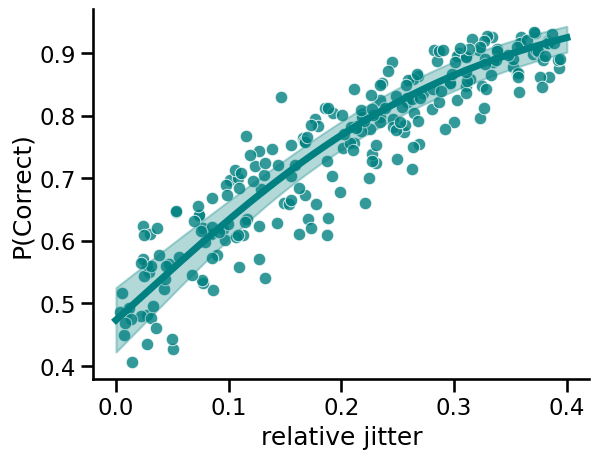

In [44]:
x_df = {'raw_top_rho_zscore' : np.tile(sample_df['raw_top_rho_zscore'].mean(), len(sample_df)), 
        'raw_btm_rho_zscore' : np.tile(sample_df['raw_btm_rho_zscore'].mean(), len(sample_df)),
        'raw_SAM_y_rho_zscore' : np.tile(sample_df['raw_SAM_y_rho_zscore'].mean(), len(sample_df)),
        'control_rho_zscore' : np.tile(sample_df['control_rho_zscore'].mean(), len(sample_df)),
        'SOA_x_zscore': np.tile(sample_df['SOA_x_zscore'].mean(), len(sample_df)),
        'rel_jitter_zscore':  np.linspace(sample_df['rel_jitter_zscore'].min(),sample_df['SOA_x_zscore'].max(),len(sample_df)), #'rel_jitter_zscore':  np.linspace(sample_df['rel_jitter_zscore'].min(),sample_df['rel_jitter_zscore'].max(),len(sample_df)),
        'n_tones_zscore' : np.tile(sample_df['n_tones_zscore'].mean(), len(sample_df))}

pred = log_reg.get_prediction(x_df)
pred_summary = pred.summary_frame(alpha=0.05)  # 95% confidence intervals

# Extract confidence intervals
ci_lower = pred_summary['ci_lower']
ci_upper = pred_summary['ci_upper']

x_dat = np.linspace(0,0.4, len(sample_df))

sns.scatterplot(x=sample_df['rel_jitter'], y=y, color='teal', alpha=0.8)
plt.plot(x_dat, pred_summary['predicted'], color='teal', lw=5)
plt.fill_between(x_dat, ci_lower, ci_upper, color='teal', alpha=0.3)
plt.xlabel('relative jitter')
plt.ylabel('P(Correct)')
sns.despine()

# panel E

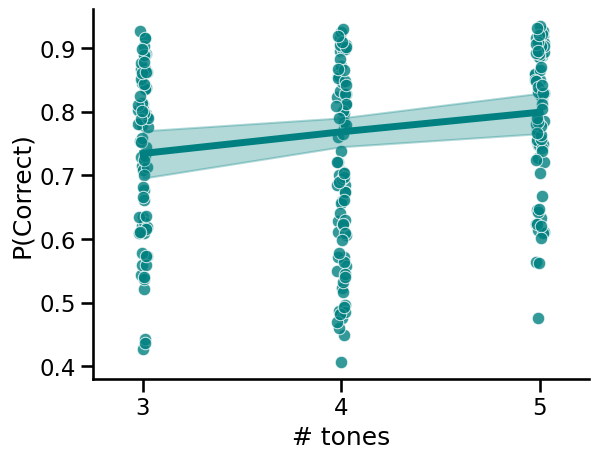

In [47]:
x_df = {'raw_top_rho_zscore' : np.tile(sample_df['raw_top_rho_zscore'].mean(), len(sample_df)), 
        'raw_btm_rho_zscore' : np.tile(sample_df['raw_btm_rho_zscore'].mean(), len(sample_df)),
        'raw_SAM_y_rho_zscore' : np.tile(sample_df['raw_SAM_y_rho_zscore'].mean(), len(sample_df)),
        'control_rho_zscore' : np.tile(sample_df['control_rho_zscore'].mean(), len(sample_df)),
        'SOA_x_zscore': np.tile(sample_df['SOA_x_zscore'].mean(), len(sample_df)),
        'rel_jitter_zscore':  np.tile(sample_df['rel_jitter_zscore'].mean(), len(sample_df)),
        'n_tones_zscore' : sample_df['n_tones_zscore'].sort_values()}

pred = log_reg.get_prediction(x_df)
pred_summary = pred.summary_frame(alpha=0.05)  # 95% confidence intervals

# Extract confidence intervals
ci_lower = pred_summary['ci_lower']
ci_upper = pred_summary['ci_upper']


ax = sns.scatterplot(x=sample_df['n_tones'].sort_values()+(np.random.rand(len(sample_df))-0.5)*0.05, y=y, color='teal', alpha=0.8)
plt.plot(sample_df['n_tones'].sort_values(), pred_summary['predicted'], color='teal', lw=5)
plt.fill_between(sample_df['n_tones'].sort_values(), ci_lower, ci_upper, color='teal', alpha=0.3)

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_xlabel('# tones')
ax.set_ylabel('P(Correct)')
ax.set_xlim([2.75,5.25])
sns.despine()